In [1]:
import os
import contextlib
import math

import torch
import torch.distributions as dist
import zuko

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

import shapely

import xarray as xr
import pandas as pd

import cartopy.crs as ccrs


from utils import *

In [2]:
from geographic_data import area_boundaries, landmarks
from geographic_data import bp_ccs_area_1_latlon, bp_ccs_area_2_latlon, endurance_area_latlon
from geographic_data import hornsea_4_latlon

from utils import plot_cities

lat_min, lon_min = np.min(area_boundaries, axis=0)
lat_max, lon_max = np.max(area_boundaries, axis=0)

print(f"Latitude: {lat_min} - {lat_max}")
print(f"Longitude: {lon_min} - {lon_max}")

study_area = shapely.geometry.Polygon(area_boundaries)

Latitude: 52.0 - 56.0
Longitude: -2.0 - 2.0


In [3]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.inventory import read_inventory


if not os.path.exists('endurance_land_stations.xml'):
    fdsn_client = Client('IRIS')

    #TODO: UKarray (UR) stations are not available on fdsn

    inv = fdsn_client.get_stations(
        network='GB,UR',
        starttime=UTCDateTime('2023-01-01'),
        minlatitude=lat_min, maxlatitude=lat_max, 
        minlongitude=lon_min, maxlongitude=lon_max,
        level='channel'
        )

    inv.write('endurance_land_stations.xml', format='stationxml')

else:
    inv = read_inventory('endurance_land_stations.xml')


seismic_inventory = {}
for sta in inv[0]:
    seismic_inventory[sta.code] = {'latitude': sta.latitude, 'longitude': sta.longitude, 'elevation': sta.elevation}
seismic_inventory = pd.DataFrame(seismic_inventory).T

In [4]:
topo_filepath = 'data/south_west_UK_SRTM15Plus.asc'

topo_data = np.loadtxt(topo_filepath, skiprows=6)

topo_data = xr.DataArray(
    data=topo_data.T,
    dims=['E', 'N'],
    coords=dict(
        N=np.linspace(lat_min, lat_max, topo_data.shape[0])[::-1],
        E=np.linspace(lon_min, lon_max, topo_data.shape[1]),
    ),
    )

N_xy = 100

topo_data = topo_data.rename({'E': 'longitude', 'N': 'latitude'})
topo_data = topo_data.interp(latitude=np.linspace(lat_min, lat_max, N_xy), longitude=np.linspace(lon_min, lon_max, N_xy))

topo_data = add_distance_coordinates(topo_data)

In [5]:
bp_ccs_area_1_xy  = latlong2xy(bp_ccs_area_1_latlon[:, 0], bp_ccs_area_1_latlon[:, 1], topo_data)
bp_ccs_area_2_xy  = latlong2xy(bp_ccs_area_2_latlon[:, 0], bp_ccs_area_2_latlon[:, 1], topo_data)
endurance_area_xy = latlong2xy(endurance_area_latlon[:, 0], endurance_area_latlon[:, 1], topo_data)
hornsea_4_xy      = latlong2xy(hornsea_4_latlon[:, 0], hornsea_4_latlon[:, 1], topo_data)

In [6]:
dx, dy = topo_data.coords['E'].diff('E')[1].data, topo_data.coords['N'].diff('N')[1].data

z_max =   600 # m
z_min = -3600 # m

dz = 50 # m

N_z = int((z_max - z_min) / dz)

z = np.linspace(z_max, z_min, N_z)

In [7]:
seimic3Dmodel = construct3Dseismicmodel(z, topo_data)

In [8]:
from utils import latlong2xy

wells_coords_latlon = np.array(
    [[54.20020528, 0.9916635 , -1020.0],
     [54.24513067, 0.97697506, -1020.0],
     [54.23250939, 1.03511106, -1020.0],
     [54.19777192, 1.05146139, -1020.0],
     [54.21851681, 0.96272839, -1020.0],]
)

well_coords_xy = np.hstack( [latlong2xy(wells_coords_latlon[:, 0], wells_coords_latlon[:, 1], topo_data), wells_coords_latlon[:, 2].reshape(-1, 1)])

In [9]:
prior_weights    = torch.ones(well_coords_xy.shape[0]).float()
prior_means      = torch.from_numpy(well_coords_xy).float()
prior_covariance = torch.eye(prior_means.shape[1]).expand(prior_means.shape[0], -1, -1) * torch.tensor([5e3, 5e3, 5e2])**2

prior_dist = zuko.distributions.Mixture(dist.MultivariateNormal(
    loc=prior_means, covariance_matrix=prior_covariance), prior_weights)

prior_samples_test = prior_dist.sample((1000,))

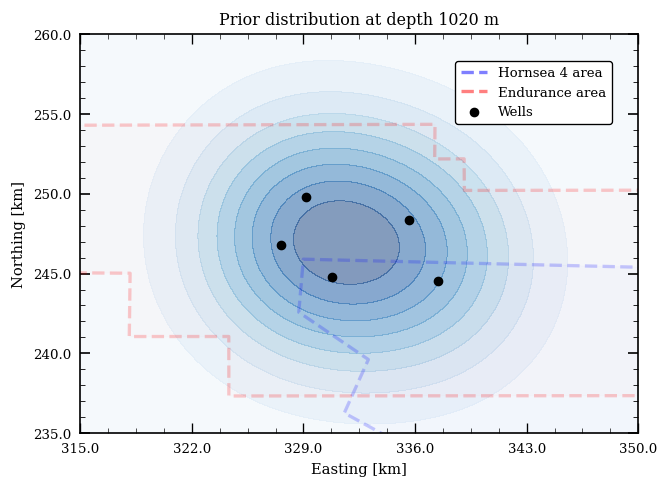

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

local_x_min = 315_000
local_x_max = 350_000
local_y_min = 235_000
local_y_max = 260_000

p_grid_X, p_grid_Y = torch.meshgrid(torch.linspace(local_x_min, local_x_max, 100), torch.linspace(local_y_min, local_y_max, 100), indexing='ij')
p_grid = torch.stack([p_grid_X, p_grid_Y, torch.ones_like(p_grid_X)*-1020], axis=-1)
p_prior = prior_dist.log_prob(p_grid).exp().numpy()

ax.contourf(p_grid_X, p_grid_Y, p_prior, levels=10, cmap='Blues', alpha=0.5, zorder=0)

ax.plot(hornsea_4_xy[:, 0], hornsea_4_xy[:, 1], color='blue', linewidth=2, alpha=0.2, linestyle='--')
ax.fill(hornsea_4_xy[:, 0], hornsea_4_xy[:, 1], color='blue', alpha=0.01)
ax.plot([], [], color='blue', linewidth=2, alpha=0.5, linestyle='--', label='Hornsea 4 area')


ax.plot(endurance_area_xy[:, 0], endurance_area_xy[:, 1], color='red', linewidth=2, alpha=0.2, linestyle='--')
ax.fill(endurance_area_xy[:, 0], endurance_area_xy[:, 1], color='red', alpha=0.01,)
ax.plot([], [], color='red', linewidth=2, alpha=0.5, linestyle='--', label='Endurance area')

ax.scatter(
    well_coords_xy[:, 0], well_coords_xy[:, 1],
    marker='.', color='black', label='Wells', s=100)

# ax.scatter(
#     prior_samples_test[:, 0], prior_samples_test[:, 1],
#     marker='x', color='blue', label='Wells', s=10)

ax.set_xlim((local_x_min, local_x_max))
ax.set_ylim((local_y_min, local_y_max))

ax.set_xticks(np.linspace(local_x_min, local_x_max, 6))
ax.set_yticks(np.linspace(local_y_min, local_y_max, 6))

ax.set_xticklabels([f'{x/1000:.1f}' for x in np.linspace(local_x_min, local_x_max, 6)])
ax.set_yticklabels([f'{y/1000:.1f}' for y in np.linspace(local_y_min, local_y_max, 6)])

ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')

ax.set_aspect('equal', 'box')

ax.set_title('Prior distribution at depth 1020 m')

legend = ax.legend(loc='upper right', frameon=True, facecolor='white')

# fig.colorbar(im, label='meters', shrink=0.5, ax=ax, pad=0.1)

plt.show()

In [11]:
receivers_latlon = seismic_inventory.to_numpy()

receivers_xy = latlong2xy(receivers_latlon[:, 0], receivers_latlon[:, 1], topo_data)
receivers_xy = torch.from_numpy(np.hstack([receivers_xy, receivers_latlon[:, 2].reshape(-1, 1)]))

mine_latlon = np.array([landmarks['lat']['Bulby Mine'], landmarks['lon']['Bulby Mine']])[None, :]
mine_xy = latlong2xy(mine_latlon[:, 0], mine_latlon[:, 1], topo_data)

mine_depth = -1400
mine_xy = np.array([mine_xy[0, 0], mine_xy[0, 1], mine_depth])

receivers_mine_xy = np.vstack([mine_xy, receivers_xy])

# Neural Eikonal Solver

In [12]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

import NES

x = seimic3Dmodel['x'].data
y = seimic3Dmodel['y'].data
z = seimic3Dmodel['z'].data


Vel = NES.Interpolator(seimic3Dmodel['vp'].data, x, y, z)

2023-08-21 13:49:24.943565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Initialization
import tensorflow as tf
from tqdm.keras import TqdmCallback

Eik = NES.NES_TP(velocity=Vel, # velocity model (see NES.Interpolator)
                #  eikonal=eikonal # optional, by default isotropic eikonal equation
                 )

Eik.build_model(
    nl=5, # number of layers
    nu=100, # number of units (may be a list)
    act='ad-gauss-1', # acivation funciton ('ad' means adaptive, '1' means slope scale)
    out_act='ad-sigmoid-1', # output activation, 'sigmoid' stands for improved factorization
    input_scale=True, # inputs scaling
    factored=True, # factorization
    out_vscale=True, # constraining by the slowest and the fastest solutions
    reciprocity=True, # symmetrizaion for the reciprocity principle 
    )

Eik.compile(
    optimizer=None, # optimizer can be set manually
    loss='mae', # loss function
    lr=0.003, # learning rate for Adam optimizer
    decay=0.0005 # decay rate for Adam optimizer
    )

In [14]:
filepath_eikonal_nn = 'NES-TP_Model_endurance'

if os.path.exists(filepath_eikonal_nn):
    Eik = NES.NES_TP.load(filepath_eikonal_nn)
else:
    num_pts = 50000
    h = Eik.train(
        x_train=num_pts, # number of random colocation points for training
        tolerance=2e-3, # tolerance value for early stopping (expected error with 2nd-order f-FMM)
        epochs=1000,
        verbose=0,
        callbacks=[TqdmCallback(verbose=0, miniters=10, mininterval=5)], # progress bar
        batch_size=int(num_pts/4),
    )
    
    plt.plot(h.history['loss'])
    plt.yscale('log')
    plt.show()
    
    Eik.save(filepath_eikonal_nn, # path and filename which defines the folder with saved model
            save_optimizer=False, # optimizer state can be saved to continue training
            training_data=False) # training data can be saved

Loaded model from "NES-TP_Model_endurance"


# Optimal Design

In [15]:
class Endurance_Traveltimes:
    def __init__(self, eikonal_nn_path, topo_data):
        self.topo_data = topo_data
        self.eikonal_nn_path = eikonal_nn_path
        self.eikonal_nn = None

    def _load_eikonal(self):
        if self.eikonal_nn is None:
            with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # suppress print
                self.eikonal_nn = NES.NES_TP.load(self.eikonal_nn_path)
        else:
            pass
        
    def _discard_eikonal(self):
        del self.eikonal_nn
        self.eikonal_nn = None

    def forward(self, design, model_samples, **kwargs):
        
        self._load_eikonal()
                
        inp = self._prepare_input(design, model_samples)
        out = self.eikonal_nn.Traveltime(inp, verbose=0)
        
        out = out.reshape(model_samples.shape[0], design.shape[0])
        
        self._discard_eikonal()
        
        return torch.from_numpy(out)
    
    def hessian(self, design, model_samples, **kwargs):

        self._load_eikonal()
                
        inp = self._prepare_input(design, model_samples)
        
        out_flat = self.eikonal_nn.HessianS(inp, verbose=0)
                
        out_flat = out_flat.reshape(model_samples.shape[0], design.shape[0], model_samples.shape[-1]*2)
                
        out = np.zeros((model_samples.shape[0], design.shape[0], 3, 3))
        out[..., np.triu_indices(3)[0], np.triu_indices(3)[1]] = out_flat
        out[..., np.tril_indices(3)[0], np.tril_indices(3)[1]] = out_flat
        
        self._discard_eikonal()
        
        return torch.from_numpy(out)
    
    def jacobian(self, design, model_samples,  **kwargs):
        
        self._load_eikonal()

        inp = self._prepare_input(design, model_samples)
        out_flat = self.eikonal_nn.GradientS(inp, verbose=0)
        out = out_flat.reshape(model_samples.shape[0], design.shape[0], model_samples.shape[-1])
        
        self._discard_eikonal()
        
        return torch.from_numpy(out)
    
    def _prepare_input(self, design, model_samples, **kwargs):
        
        receivers = design[:, :3]
        
        inp_indices = np.indices((model_samples.shape[0], receivers.shape[0])).reshape(2, -1).T
        inp = np.hstack((model_samples[inp_indices[:,0]], receivers[inp_indices[:,1]]))
        
        return inp
    


In [16]:
def data_likelihood(samples, design=None):
    std_data = 0.5
    return dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)

In [17]:
from geobed.continuous.core import BED_Class

filepath = 'data/Endurance_CCS/Endurance_CCS_StudyArea.shp'

Forward_Class = Endurance_Traveltimes(filepath_eikonal_nn, topo_data)

Test_BED_Class = BED_Class(
    forward_function=Forward_Class,
    obs_noise_dist=data_likelihood,
    m_prior_dist=prior_dist,
    # model_parameter_prior_samples=,
    # nuisance_dist=,
    # nuisance_parameter_samples=nuisance_parameter_samples,
    )

In [18]:
n_visual_model_samples = int(1e4)

design_list = torch.from_numpy(receivers_mine_xy).unsqueeze(1)

clean_data = Test_BED_Class.get_forward_function_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze()

noisy_data = Test_BED_Class.get_forward_model_samples(
    design_list.squeeze(),
    n_samples_model=n_visual_model_samples,
    n_samples_nuisance=1,
    random_seed_model=1,
    random_seed_nuisance=2,
    ).squeeze() 

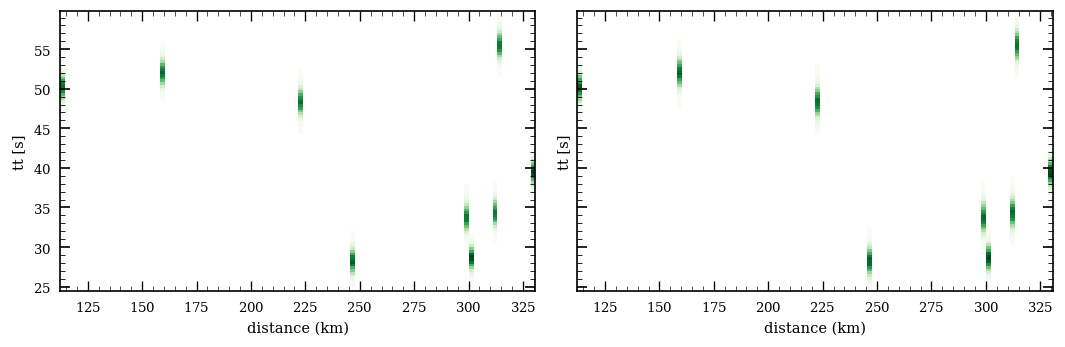

In [19]:
# with style.context('./mpl_stylesheet.mplstyle'):
fig = plt.figure(figsize=(9, 3))
ax_dict = fig.subplot_mosaic(
    '''ab''',
    # gridspec_kw={'wspace': 0.2},
    sharex=True, sharey=True)

ax_dict['a'].hist2d(
    np.sqrt(design_list.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()**2 + \
    design_list.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()**2)/1e3,
    clean_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(
    np.sqrt(design_list.squeeze()[:, 1].expand(n_visual_model_samples, -1).flatten().numpy()**2 + \
    design_list.squeeze()[:, 0].expand(n_visual_model_samples, -1).flatten().numpy()**2)/1e3,
    noisy_data.flatten().numpy(),
    bins=[100, 100], cmap='Greens', cmin=1)
    
ax_dict['a'].set_ylabel('tt [s]')
ax_dict['b'].set_ylabel('tt [s]')

ax_dict['a'].set_xlabel('distance (km)')
ax_dict['b'].set_xlabel('distance (km)')

plt.tight_layout()
plt.show()

In [20]:
filepath = 'data/Endurance_CCS/Endurance_CCS_StudyArea.shp'

Forward_Class = Endurance_Traveltimes(filepath_eikonal_nn, topo_data)


def data_likelihood(samples, design=None):    
    
    cov_matrix = torch.eye(samples.shape[-1]) * design[:, -1]

    return dist.MultivariateNormal(samples, covariance_matrix=cov_matrix)


Test_BED_Class = BED_Class(
    forward_function=Forward_Class,
    obs_noise_dist=data_likelihood,
    m_prior_dist=prior_dist,
    # model_parameter_prior_samples=,
    # nuisance_dist=,
    # nuisance_parameter_samples=nuisance_parameter_samples,
    )

In [21]:
seismometer_noise_level = 0.5

mine_relative_noise_level = np.logspace(2, -4, 21)

design_list = []

for nl_i in mine_relative_noise_level:

    design_i = torch.from_numpy(receivers_mine_xy)
    # add column with noiselevel

    std_array = torch.ones(design_i.shape[0], 1) * seismometer_noise_level
    std_array[0] *= nl_i

    design_i = torch.cat((design_i, std_array), dim=1)
    
    design_list.append(design_i)
    
design_list = torch.stack(design_list).float()

print(design_list.dtype)

torch.float32


In [22]:
prior_samples_test = prior_dist.sample((int(1e6),))

print(prior_samples_test.shape)

torch.Size([1000000, 3])


In [23]:
T = int(1e2)

eig_dn, out_dn = Test_BED_Class.calculate_EIG(
    design=design_list[:1],
    eig_method='Laplace',
    eig_method_kwargs={'laplace_type': 'model', 'N': T},
    num_workers=1,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_laplace_m',
)

torch.Size([100, 3])
torch.Size([9, 4])
[[ 3.23174062e+05  2.41026359e+05 -1.34699048e+03  1.29679695e+05
   2.84683500e+05 -1.40000000e+03]
 [ 3.23174062e+05  2.41026359e+05 -1.34699048e+03  7.65545391e+04
   8.21595859e+04  2.03000000e+02]
 [ 3.23174062e+05  2.41026359e+05 -1.34699048e+03  4.02495190e+03
   3.14977000e+05  3.37000000e+02]
 ...
 [ 3.28139406e+05  2.42776859e+05 -1.26383740e+03  3.04416426e+04
   1.55930984e+05  3.53000000e+02]
 [ 3.28139406e+05  2.42776859e+05 -1.26383740e+03  1.84947438e+05
   1.62127500e+05  1.33000000e+02]
 [ 3.28139406e+05  2.42776859e+05 -1.26383740e+03  2.90435312e+05
   8.06135156e+04  6.60000000e+01]]
(900, 6)
torch.Size([100, 9, 3, 3])
torch.Size([100, 9, 3])


TypeError: 'NoneType' object is not iterable

In [ ]:
exit

In [ ]:
def nmc_partition(T):
    M = math.pow(T, 1/3)
    N = M*M
    return int(N), int(M)

T = int(1e6)
N, M = nmc_partition(T)

eig_nmc, out_nmc = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='NMC',
    eig_method_kwargs={'N': N, 'M': M, 'reuse_M':True, 'memory_efficient':True},
    num_workers=1,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_nmc',
)

In [ ]:
T = int(1e4)

eig_dn, out_dn = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='DN',
    eig_method_kwargs={'N': T, },
    num_workers=1,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_dn',
)

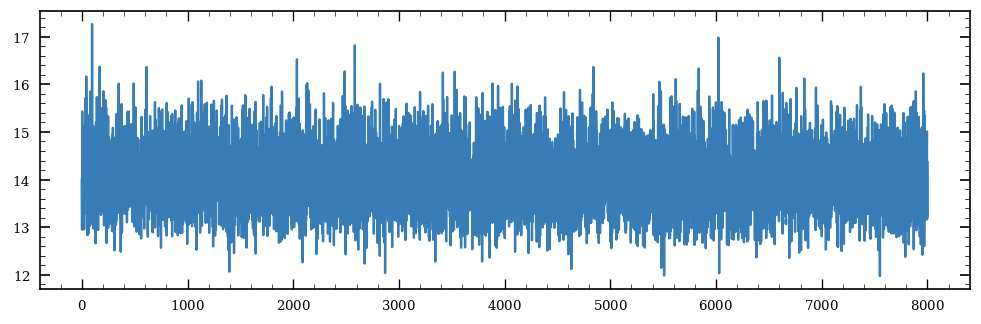

In [ ]:
from geobed.discrete.guides import GMM_guide

T = int(1e5)
N = int(0.2*T)
M = int(0.8*T)

n_batch = 10
n_epochs = 1

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-2
min_lr = 1e-4
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_varmarg, out_varmarg = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='variational_marginal',
    eig_method_kwargs=
        {'guide': GMM_guide,
        'N': N,
        'M': M,
        'guide_kwargs': {'components':10, 'init_method': {'init_params': 'k-means++', 'n_init': 10, 'max_iter': 1}},
        'n_batch': n_batch,
        'n_epochs': n_epochs,
        # 'optimizer': None,
        'optimizer_kwargs': {'lr': max_lr},
        'scheduler': scheduler,
        'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
        'return_guide': True,
        'return_train_loss': True,
        'return_test_loss': True,
        },
    num_workers=10,
    parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_varmarg',
)

plt.figure(figsize=(10, 3))
plt.plot(out_varmarg[0]['train_loss'], label='train loss')
plt.show()

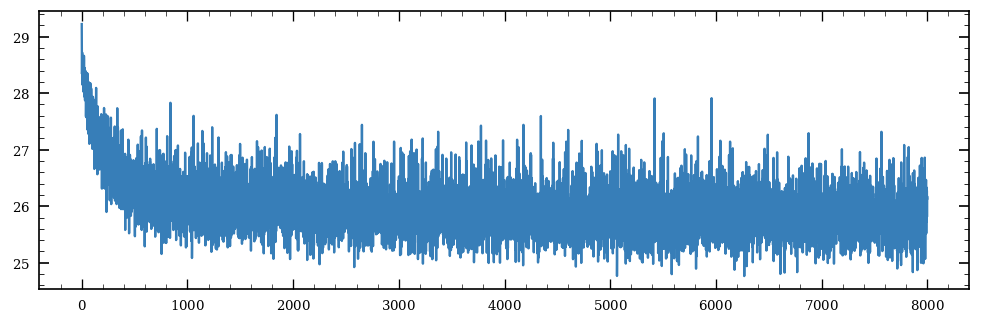

In [ ]:
from geobed.discrete.guides import MDN_guide

T = int(1e5)
N = int(0.2*T)
M = int(0.8*T)

n_batch = 10
n_epochs = 1

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-4
min_lr = 1e-6
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_varpost, out_varpost = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='variational_posterior',
    eig_method_kwargs=
        {'guide': MDN_guide,
        'N': N,
        'M': M,
        'guide_kwargs': {'components':20, 'hidden_features':[200, 200, 200], 'normalize':True},
        'n_batch': n_batch,
        'n_epochs': n_epochs,
        # 'optimizer': None,
        'optimizer_kwargs': {'lr': max_lr},
        'scheduler': scheduler,
        'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
        'return_guide': True,
        'return_train_loss': True,
        'return_test_loss': True,
        },
    num_workers=10,
    parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_varpost',
)

plt.figure(figsize=(10, 3))
plt.plot(out_varpost[0]['train_loss'], label='train loss')
plt.show()

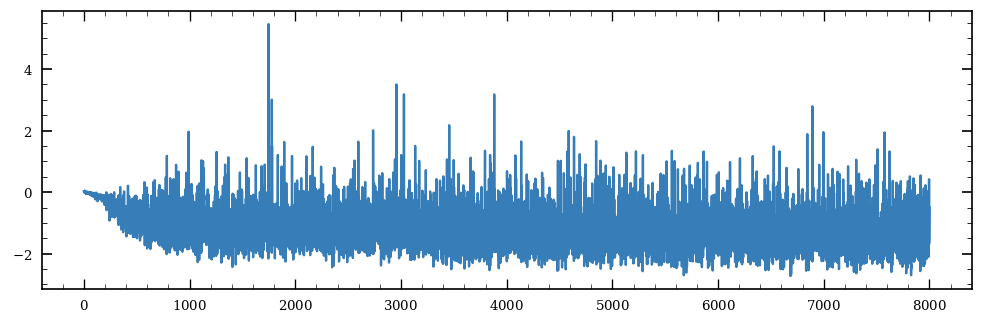

In [ ]:
from geobed.discrete.guides import MLP_FLO

T = int(1e5)
N = int(0.2*T)
M = int(0.8*T)

n_batch = 10
n_epochs = 1

scheduler = torch.optim.lr_scheduler.ExponentialLR
max_lr = 1e-4
min_lr = 1e-6
gamma  = (min_lr/max_lr)**(n_batch/(n_epochs*M))

eig_FLO, out_FLO = Test_BED_Class.calculate_EIG(
    design=design_list,
    eig_method='FLO',
    eig_method_kwargs=
        {'guide': MLP_FLO,
        'N': N,
        'M': M,
        'K': 'adaptive',
        'guide_kwargs': {'H':[100, 100, 100, 100,],},
        # 'guide_kwargs': {'H':[500, 500,],},
        'n_batch': n_batch,
        'n_epochs': n_epochs,
        # 'optimizer': None,
        'optimizer_kwargs': {'lr': max_lr},
        'scheduler': scheduler,
        'scheduler_kwargs': {'gamma':gamma, 'verbose':False},
        'return_guide': True,
        'return_train_loss': True,
        'return_test_loss': True,
        },
    num_workers=10,
    # parallel_library='joblib',
    random_seed=1,
    filename='data/endurance_study_eig_FLO',
)

plt.figure(figsize=(10, 3))
plt.plot(out_FLO[0]['train_loss'], label='train loss')
plt.show()

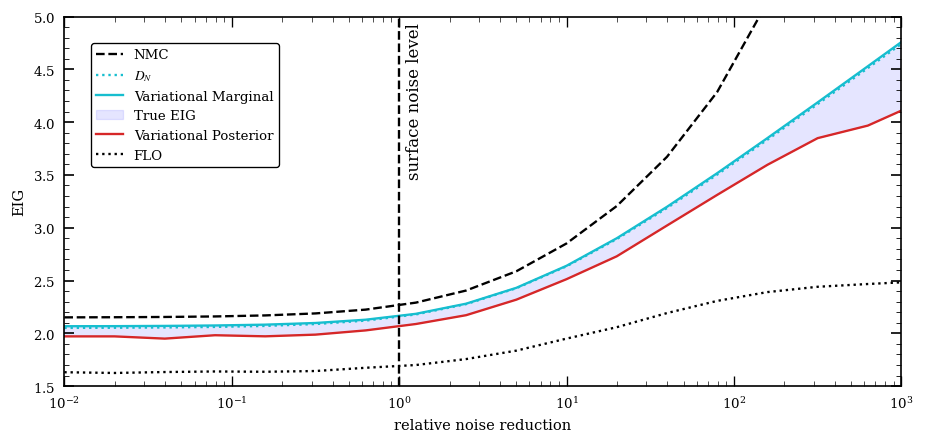

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(1/mine_relative_noise_level, eig_nmc, label="NMC", color="black", linestyle="--")
ax.plot(1/mine_relative_noise_level, eig_dn, label=r"$D_N$", color="tab:cyan", linestyle=":")
ax.plot(1/mine_relative_noise_level, eig_varmarg, label="Variational Marginal", color="tab:cyan")

ax.fill_between(1/mine_relative_noise_level, eig_varmarg, eig_varpost, alpha=0.1, color="blue", label='True EIG')

ax.plot(1/mine_relative_noise_level, eig_varpost, label="Variational Posterior", color="tab:red")
ax.plot(1/mine_relative_noise_level, eig_FLO, label="FLO", color="black", linestyle=":")


ax.axvline(1, color="black", linestyle="--")
ax.text(1.1, 3.5, "surface noise level", rotation=90)

ax.set_xlabel("relative noise reduction")
ax.set_ylabel("EIG")

ax.set_xlim(0.01, 1000)
ax.set_ylim(1.5, 5)

ax.set_xscale("log")

ax.legend()

plt.show()